In [5]:
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from keras import regularizers
from keras import callbacks

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

from IPython.display import display

Using TensorFlow backend.


In [6]:
def grab_image(img_path, x, y):
    img = image.load_img(img_path, color_mode = "grayscale", target_size=(x,y))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
def get_csv(n, path) :
    data = pd.read_csv(path, header=None)
    output = data[0].values
    
    if n == 0 :
        return output
    else :
        return output[:n]

In [8]:

num_images = 800
human_scores = get_csv(num_images, '/home/djw4s/miscImgs/scores/humanScores.txt')
print(human_scores.shape)

(800,)


In [9]:
images = np.concatenate([grab_image('/home/djw4s/miscImgs/models/%d_model.png'%(i), 100, 100) for i in range(num_images)])

images /= 255
print(images.shape)

(800, 100, 100, 1)


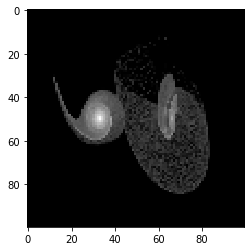

0.72973

In [10]:
plt.imshow(image.array_to_img(images[45,:,:,:]), cmap='Greys_r')
plt.show()
display(human_scores[45])

In [11]:
p = np.random.permutation(len(images))
Xshuffled = images[p]
Yshuffled = human_scores[p]

display(Xshuffled.shape)
display(Yshuffled.shape)

(800, 100, 100, 1)

(800,)

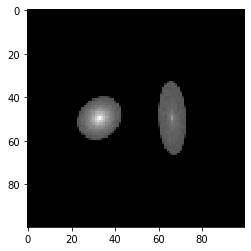

0.083333

In [12]:
plt.imshow(image.array_to_img(Xshuffled[0,:,:,:]), cmap='Greys_r')
plt.show()
display(Yshuffled[0])

In [13]:
x_train = Xshuffled[0:(round(200*.85)),:,:]
y_train = Yshuffled[0:(round(200*.85))]
x_test = Xshuffled[(round(200*.85)): , : , :]
y_test = Yshuffled[(round(200*.85)):]

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(170, 100, 100, 1)

(170,)

(630, 100, 100, 1)

(630,)

In [14]:
#csvLogger = callbacks.CSVLogger('training.csv')
model = keras.Sequential()
# 1st block:
model.add(keras.layers.Conv2D(32, kernel_size=(8,8),
                              padding='same', 
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]
                                          ]
                             )
         )
model.add(keras.layers.Conv2D(64, (8, 8), activation='relu', strides=2))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
# Dense Layers:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
#model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy', 'mse']
             )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        131136    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                541712    
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [15]:
batch_size = 10
epochs = 50
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.2
                   )
print('DONE')

Train on 136 samples, validate on 34 samples
Epoch 1/50
 - 4s - loss: 0.0885 - accuracy: 0.0000e+00 - mse: 0.0885 - val_loss: 0.0359 - val_accuracy: 0.0000e+00 - val_mse: 0.0359
Epoch 2/50
 - 3s - loss: 0.0701 - accuracy: 0.0000e+00 - mse: 0.0701 - val_loss: 0.0458 - val_accuracy: 0.0000e+00 - val_mse: 0.0458
Epoch 3/50
 - 3s - loss: 0.0715 - accuracy: 0.0000e+00 - mse: 0.0715 - val_loss: 0.0506 - val_accuracy: 0.0000e+00 - val_mse: 0.0506
Epoch 4/50
 - 3s - loss: 0.0699 - accuracy: 0.0000e+00 - mse: 0.0699 - val_loss: 0.0341 - val_accuracy: 0.0000e+00 - val_mse: 0.0341
Epoch 5/50
 - 3s - loss: 0.0619 - accuracy: 0.0000e+00 - mse: 0.0619 - val_loss: 0.0376 - val_accuracy: 0.0000e+00 - val_mse: 0.0376
Epoch 6/50
 - 3s - loss: 0.0581 - accuracy: 0.0000e+00 - mse: 0.0581 - val_loss: 0.0378 - val_accuracy: 0.0000e+00 - val_mse: 0.0378
Epoch 7/50
 - 3s - loss: 0.0616 - accuracy: 0.0000e+00 - mse: 0.0616 - val_loss: 0.0372 - val_accuracy: 0.0000e+00 - val_mse: 0.0372
Epoch 8/50
 - 3s - loss:

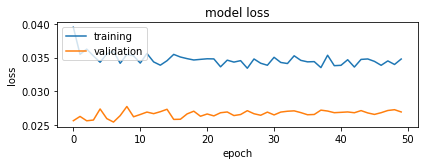

In [33]:
plt.figure(1)

plt.subplot(211)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'],loc='upper left')

plt.tight_layout()
plt.show()